In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

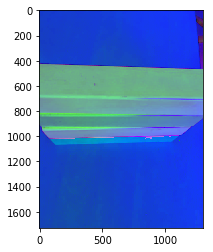

In [3]:
image = cv2.imread('images/containers1.jpg') # Opencv BGR
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
plt.show()

In [7]:
# BGR limites
boundaries = [
	([17, 15, 100], [50, 56, 200]),
	([46, 31, 4], [220, 88, 50]),
	([25, 146, 190], [62, 174, 250]),
	([103, 86, 65], [145, 133, 128])
]
red_boundary = [([17, 15, 100], [50, 56, 200])]

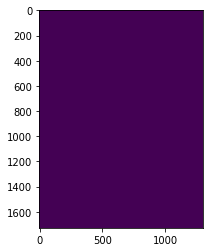

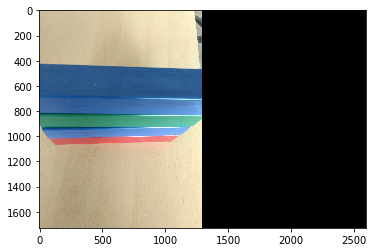

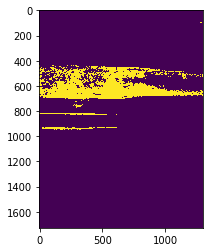

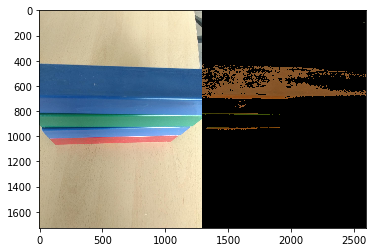

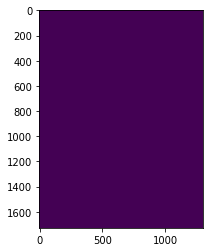

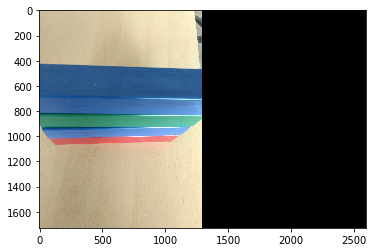

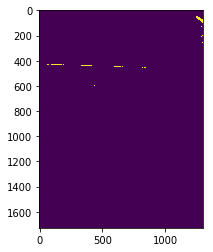

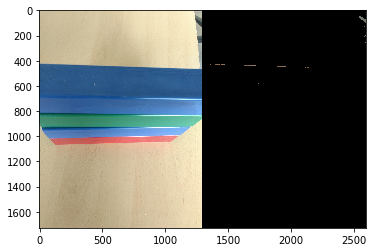

In [8]:
for (lower, upper) in boundaries:
    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(mask)
    plt.show()
    plt.imshow(np.hstack([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), output]))
    #cv2.waitKey(0)
    plt.show()

# Shape detector

In [3]:
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import numpy as np

In [9]:
class ShapeDetector:
    def __init__(self):
        pass
    
    def detect(self, c):
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            
            shape = "Square" if ar >= 0.95 and ar <= 1.05 else "Rectangle"
        
        elif len(approx) == 5:
            shape = "Pentagon"
            
        else:
            shape = "Circle"
            
        return shape

In [10]:
t1 = time.time()
image = cv2.imread("images/containers1.jpg")
resized = imutils.resize(image, width=300)
ratio = image.shape[0] / float(resized.shape[0])

# convert the resized image to grayscale, blur it slightly,
# and threshold it
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
sd = ShapeDetector()

for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)

    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    # show the output image
print(time.time() - t1)
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.07900857925415039


In [ ]:
# Convert BGR to HSV
frame = cv2.imread("images/containers1.jpg")
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# define range of blue color in HSV
lower_blue = np.array([110,50,50])
upper_blue = np.array([130,255,255])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)

cv2.imshow('frame',frame)
cv2.imshow('mask',mask)
cv2.imshow('res',res)
cv2.waitKey(0)
cv2.destroyAllWindows()

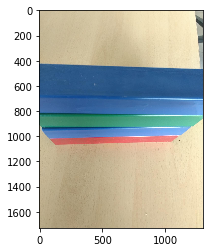

In [7]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(hsv)
plt.show()